In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_AR_v5 import AR_RNN_GRU as RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-11-13 22:55:26.241181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.241705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.295380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.295703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.296051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-13 22:55:26.299303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.299687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.300037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.918886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 22:55:26.919130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_024'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_rnn/AR_rnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_rnn_specific_data, set to 1.")
        skip_intermediate = 1

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_arr = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_ARrnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']
lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_ARrnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_024
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

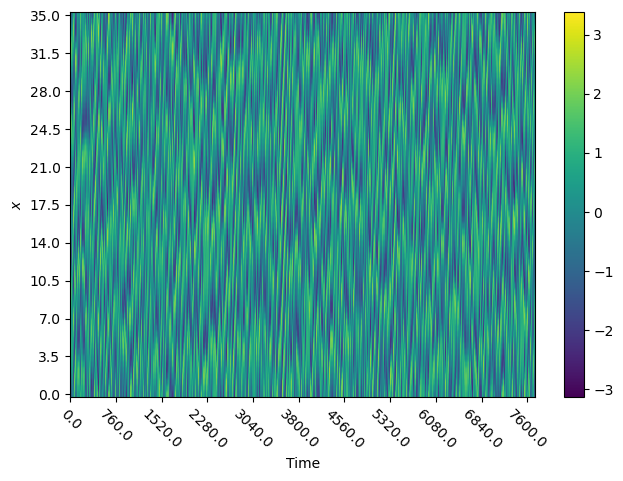

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

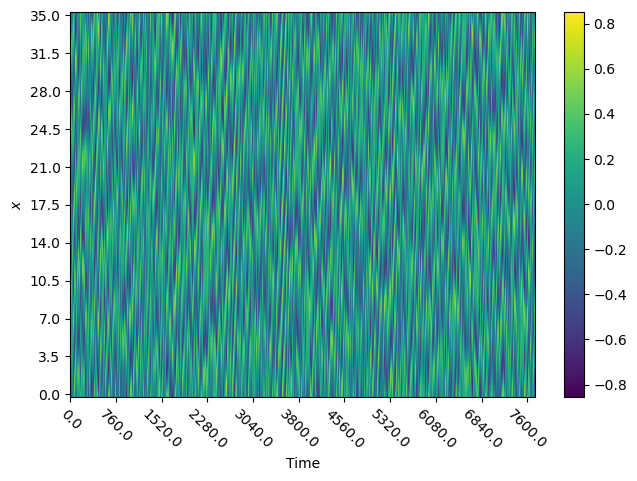

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [18]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

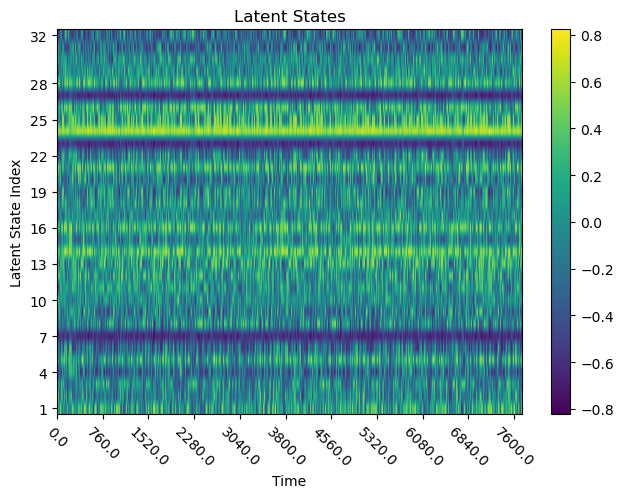

In [20]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 8*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 50#1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = 8*dt_rnn # num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 1/4
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'skip_intermediate':skip_intermediate,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [23]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
    return_OrgDataIdxArr=False,
    skip_intermediate=skip_intermediate,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [24]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [25]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-4, 1e-5]
    epochs = 2000
    patience = 50 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )

In [26]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [27]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [28]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                T_input=T_sample_input,
                T_output=T_sample_output,
                stddev=stddev,
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            T_input=T_sample_input,
            T_output=T_sample_output,
            stddev=stddev,
        )
    save_path = dir_name_ARrnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ARrnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            stddev=stddev
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ARrnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)

In [29]:
# comment this out if not residual RNN
rnn_net.rnn_cells_list[0].trainable = False

In [30]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_ARrnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ARrnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [31]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ARrnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
34/34 [==============================] - ETA: 0s - loss: 0.1991 - tot_time: 0h 0m 18.3s

Epoch 1: val_loss improved from inf to 0.17637, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 18s 120ms/step - loss: 0.1991 - val_loss: 0.1764
Epoch 2/2000
34/34 [==============================] - ETA: 0s - loss: 0.1549 - tot_time: 0h 0m 20.9s

Epoch 2: val_loss improved from 0.17637 to 0.13935, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0800 - val_loss: 0.0799
Epoch 18/2000
34/34 [==============================] - ETA: 0s - loss: 0.0790 - tot_time: 0h 1m 2.6s

Epoch 18: val_loss improved from 0.07993 to 0.07896, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0790 - val_loss: 0.0790
Epoch 19/2000
34/34 [==============================] - ETA: 0s - loss: 0.0779 - tot_time: 0h 1m 5.2s

Epoch 19: val_loss improved from 0.07896 to 0.07781, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docum

Epoch 35/2000
34/34 [==============================] - ETA: 0s - loss: 0.0657 - tot_time: 0h 1m 47.0s

Epoch 35: val_loss improved from 0.06626 to 0.06572, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0657 - val_loss: 0.0657
Epoch 36/2000
34/34 [==============================] - ETA: 0s - loss: 0.0651 - tot_time: 0h 1m 49.6s

Epoch 36: val_loss improved from 0.06572 to 0.06504, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0651 - val_loss: 0.0650
Epoch 37/2000
34/34 [=========================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0578 - val_loss: 0.0578
Epoch 53/2000
34/34 [==============================] - ETA: 0s - loss: 0.0574 - tot_time: 0h 2m 35.2s

Epoch 53: val_loss improved from 0.05776 to 0.05732, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0574 - val_loss: 0.0573
Epoch 54/2000
34/34 [==============================] - ETA: 0s - loss: 0.0570 - tot_time: 0h 2m 37.9s

Epoch 54: val_loss improved from 0.05732 to 0.05698, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Doc

Epoch 70/2000
34/34 [==============================] - ETA: 0s - loss: 0.0511 - tot_time: 0h 3m 20.6s

Epoch 70: val_loss improved from 0.05150 to 0.05115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0511 - val_loss: 0.0511
Epoch 71/2000
34/34 [==============================] - ETA: 0s - loss: 0.0508 - tot_time: 0h 3m 23.3s

Epoch 71: val_loss improved from 0.05115 to 0.05086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0508 - val_loss: 0.0509
Epoch 72/2000
34/34 [=========================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0458 - val_loss: 0.0459
Epoch 88/2000
34/34 [==============================] - ETA: 0s - loss: 0.0455 - tot_time: 0h 4m 9.3s

Epoch 88: val_loss improved from 0.04586 to 0.04555, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0455 - val_loss: 0.0456
Epoch 89/2000
34/34 [==============================] - ETA: 0s - loss: 0.0452 - tot_time: 0h 4m 12.0s

Epoch 89: val_loss improved from 0.04555 to 0.04531, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docu

Epoch 105/2000
34/34 [==============================] - ETA: 0s - loss: 0.0409 - tot_time: 0h 4m 55.4s

Epoch 105: val_loss improved from 0.04130 to 0.04101, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0409 - val_loss: 0.0410
Epoch 106/2000
34/34 [==============================] - ETA: 0s - loss: 0.0407 - tot_time: 0h 4m 58.2s

Epoch 106: val_loss improved from 0.04101 to 0.04073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0407 - val_loss: 0.0407
Epoch 107/2000
33/34 [====================

34/34 [==============================] - ETA: 0s - loss: 0.0369 - tot_time: 0h 5m 41.1s

Epoch 122: val_loss improved from 0.03721 to 0.03697, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0369 - val_loss: 0.0370
Epoch 123/2000
34/34 [==============================] - ETA: 0s - loss: 0.0367 - tot_time: 0h 5m 43.7s

Epoch 123: val_loss improved from 0.03697 to 0.03678, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 124/2000
33/34 [============================>.] - E

34/34 [==============================] - ETA: 0s - loss: 0.0334 - tot_time: 0h 6m 25.3s

Epoch 139: val_loss improved from 0.03367 to 0.03352, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 75ms/step - loss: 0.0334 - val_loss: 0.0335
Epoch 140/2000
34/34 [==============================] - ETA: 0s - loss: 0.0332 - tot_time: 0h 6m 27.9s

Epoch 140: val_loss improved from 0.03352 to 0.03328, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 75ms/step - loss: 0.0332 - val_loss: 0.0333
Epoch 141/2000
33/34 [============================>.] - E

34/34 [==============================] - ETA: 0s - loss: 0.0303 - tot_time: 0h 7m 10.0s

Epoch 156: val_loss improved from 0.03056 to 0.03043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0303 - val_loss: 0.0304
Epoch 157/2000
34/34 [==============================] - ETA: 0s - loss: 0.0301 - tot_time: 0h 7m 12.7s

Epoch 157: val_loss improved from 0.03043 to 0.03022, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0301 - val_loss: 0.0302
Epoch 158/2000
33/34 [============================>.] - E

34/34 [==============================] - ETA: 0s - loss: 0.0275 - tot_time: 0h 7m 55.9s

Epoch 173: val_loss improved from 0.02781 to 0.02769, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 174/2000
34/34 [==============================] - ETA: 0s - loss: 0.0274 - tot_time: 0h 7m 58.5s

Epoch 174: val_loss improved from 0.02769 to 0.02753, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0274 - val_loss: 0.0275
Epoch 175/2000
34/34 [==============================] - E

34/34 [==============================] - ETA: 0s - loss: 0.0251 - tot_time: 0h 8m 41.8s

Epoch 190: val_loss improved from 0.02539 to 0.02528, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0251 - val_loss: 0.0253
Epoch 191/2000
34/34 [==============================] - ETA: 0s - loss: 0.0250 - tot_time: 0h 8m 44.6s

Epoch 191: val_loss improved from 0.02528 to 0.02517, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 192/2000
34/34 [==============================] - E

34/34 [==============================] - ETA: 0s - loss: 0.0230 - tot_time: 0h 9m 27.5s

Epoch 207: val_loss improved from 0.02335 to 0.02317, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0230 - val_loss: 0.0232
Epoch 208/2000
33/34 [============================>.] - ETA: 0s - loss: 0.0229 - tot_time: 0h 9m 30.2s

Epoch 208: val_loss improved from 0.02317 to 0.02305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0229 - val_loss: 0.0231
Epoch 209/2000
34/34 [==============================] - E

34/34 [==============================] - ETA: 0s - loss: 0.0211 - tot_time: 0h 10m 12.4s

Epoch 224: val_loss improved from 0.02138 to 0.02127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0211 - val_loss: 0.0213
Epoch 225/2000
34/34 [==============================] - ETA: 0s - loss: 0.0210 - tot_time: 0h 10m 15.3s

Epoch 225: val_loss improved from 0.02127 to 0.02119, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 83ms/step - loss: 0.0210 - val_loss: 0.0212
Epoch 226/2000
34/34 [==============================] -

34/34 [==============================] - ETA: 0s - loss: 0.0194 - tot_time: 0h 10m 57.8s

Epoch 241: val_loss improved from 0.01970 to 0.01962, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 242/2000
34/34 [==============================] - ETA: 0s - loss: 0.0193 - tot_time: 0h 11m 0.4s

Epoch 242: val_loss improved from 0.01962 to 0.01951, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0193 - val_loss: 0.0195
Epoch 243/2000
34/34 [==============================] - 

34/34 [==============================] - ETA: 0s - loss: 0.0179 - tot_time: 0h 11m 43.0s

Epoch 258: val_loss improved from 0.01822 to 0.01812, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 259/2000
34/34 [==============================] - ETA: 0s - loss: 0.0178 - tot_time: 0h 11m 45.7s

Epoch 259: val_loss improved from 0.01812 to 0.01805, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 260/2000
34/34 [==============================] -

34/34 [==============================] - ETA: 0s - loss: 0.0166 - tot_time: 0h 12m 28.2s

Epoch 275: val_loss improved from 0.01689 to 0.01682, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 276/2000
34/34 [==============================] - ETA: 0s - loss: 0.0165 - tot_time: 0h 12m 30.8s

Epoch 276: val_loss improved from 0.01682 to 0.01677, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 277/2000
34/34 [==============================] -

34/34 [==============================] - ETA: 0s - loss: 0.0154 - tot_time: 0h 13m 13.8s

Epoch 292: val_loss improved from 0.01569 to 0.01563, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 293/2000
34/34 [==============================] - ETA: 0s - loss: 0.0153 - tot_time: 0h 13m 16.5s

Epoch 293: val_loss improved from 0.01563 to 0.01556, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 294/2000
34/34 [==============================] -

34/34 [==============================] - ETA: 0s - loss: 0.0143 - tot_time: 0h 13m 60.0s

Epoch 309: val_loss improved from 0.01471 to 0.01458, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 310/2000
34/34 [==============================] - ETA: 0s - loss: 0.0143 - tot_time: 0h 14m 2.6s

Epoch 310: val_loss improved from 0.01458 to 0.01457, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 311/2000
33/34 [============================>.] - 

34/34 [==============================] - ETA: 0s - loss: 0.0134 - tot_time: 0h 14m 44.9s

Epoch 326: val_loss did not improve from 0.01371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 75ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 327/2000
34/34 [==============================] - ETA: 0s - loss: 0.0133 - tot_time: 0h 14m 47.5s

Epoch 327: val_loss improved from 0.01371 to 0.01365, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 328/2000
34/34 [==============================] - ETA: 0s - loss: 0.0133 - tot_time: 0h 14m 50.1s

Epoch 328: val_loss improved from 0.01365 to 0.01360, savin

Epoch 344/2000
34/34 [==============================] - ETA: 0s - loss: 0.0125 - tot_time: 0h 15m 32.5s

Epoch 344: val_loss improved from 0.01284 to 0.01280, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 345/2000
34/34 [==============================] - ETA: 0s - loss: 0.0125 - tot_time: 0h 15m 35.2s

Epoch 345: val_loss improved from 0.01280 to 0.01274, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 346/2000
34/34 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 362/2000
34/34 [==============================] - ETA: 0s - loss: 0.0117 - tot_time: 0h 16m 20.3s

Epoch 362: val_loss did not improve from 0.01204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 363/2000
34/34 [==============================] - ETA: 0s - loss: 0.0117 - tot_time: 0h 16m 22.9s

Epoch 363: val_loss improved from 0.01204 to 0.01201, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [=============

Epoch 380/2000
34/34 [==============================] - ETA: 0s - loss: 0.0110 - tot_time: 0h 17m 7.7s

Epoch 380: val_loss improved from 0.01141 to 0.01138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 381/2000
34/34 [==============================] - ETA: 0s - loss: 0.0110 - tot_time: 0h 17m 10.4s

Epoch 381: val_loss did not improve from 0.01138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 382/2000
34/34 [==============================] - ETA: 0s - loss: 0.0110 - tot_time: 0h 17m 13.1s

Epoch 382: val_loss improved from 0.01138 to 

Epoch 398/2000
34/34 [==============================] - ETA: 0s - loss: 0.0104 - tot_time: 0h 17m 55.5s

Epoch 398: val_loss did not improve from 0.01080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 399/2000
34/34 [==============================] - ETA: 0s - loss: 0.0104 - tot_time: 0h 17m 58.3s

Epoch 399: val_loss improved from 0.01080 to 0.01075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 400/2000
34/34 [==============================] - ETA: 0s - loss: 0.0104 - tot_time: 0h 18m 1.0s

Epoch 400: val_loss improved from 0.01075 to 

Epoch 416/2000
34/34 [==============================] - ETA: 0s - loss: 0.0099 - tot_time: 0h 18m 44.0s

Epoch 416: val_loss did not improve from 0.01025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 417/2000
34/34 [==============================] - ETA: 0s - loss: 0.0099 - tot_time: 0h 18m 46.7s

Epoch 417: val_loss improved from 0.01025 to 0.01023, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 418/2000
34/34 [==============================] - ETA: 0s - loss: 0.0098 - tot_time: 0h 18m 49.3s

Epoch 418: val_loss did not improve from 0.0

Epoch 434/2000
34/34 [==============================] - ETA: 0s - loss: 0.0094 - tot_time: 0h 19m 32.3s

Epoch 434: val_loss improved from 0.00981 to 0.00981, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 435/2000
34/34 [==============================] - ETA: 0s - loss: 0.0094 - tot_time: 0h 19m 35.0s

Epoch 435: val_loss improved from 0.00981 to 0.00975, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 436/2000
34/34 [==================

Epoch 453/2000
34/34 [==============================] - ETA: 0s - loss: 0.0090 - tot_time: 0h 20m 22.1s

Epoch 453: val_loss improved from 0.00938 to 0.00935, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 454/2000
34/34 [==============================] - ETA: 0s - loss: 0.0090 - tot_time: 0h 20m 24.7s

Epoch 454: val_loss improved from 0.00935 to 0.00935, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 455/2000
34/34 [==================

Epoch 472/2000
34/34 [==============================] - ETA: 0s - loss: 0.0086 - tot_time: 0h 21m 11.4s

Epoch 472: val_loss improved from 0.00903 to 0.00902, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 473/2000
34/34 [==============================] - ETA: 0s - loss: 0.0086 - tot_time: 0h 21m 13.9s

Epoch 473: val_loss did not improve from 0.00902
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 71ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 474/2000
34/34 [==============================] - ETA: 0s - loss: 0.0086 - tot_time: 0h 21m 16.4s

Epoch 474: val_loss improved from 0.00902 to

Epoch 491/2000
34/34 [==============================] - ETA: 0s - loss: 0.0083 - tot_time: 0h 22m 1.4s

Epoch 491: val_loss improved from 0.00873 to 0.00869, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 492/2000
34/34 [==============================] - ETA: 0s - loss: 0.0083 - tot_time: 0h 22m 3.9s

Epoch 492: val_loss did not improve from 0.00869
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 71ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 493/2000
34/34 [==============================] - ETA: 0s - loss: 0.0083 - tot_time: 0h 22m 6.4s

Epoch 493: val_loss improved from 0.00869 to 0.

Epoch 510/2000
34/34 [==============================] - ETA: 0s - loss: 0.0080 - tot_time: 0h 22m 50.6s

Epoch 510: val_loss did not improve from 0.00845
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 511/2000
34/34 [==============================] - ETA: 0s - loss: 0.0080 - tot_time: 0h 22m 53.3s

Epoch 511: val_loss did not improve from 0.00845
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 80ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 512/2000
34/34 [==============================] - ETA: 0s - loss: 0.0080 - tot_time: 0h 22m 56.0s

Epoch 512: val_loss improved from 0.00845 to 0.00844, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkp

34/34 [==============================] - ETA: 0s - loss: 0.0078 - tot_time: 0h 23m 42.1s

Epoch 529: val_loss did not improve from 0.00825
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 530/2000
34/34 [==============================] - ETA: 0s - loss: 0.0078 - tot_time: 0h 23m 44.8s

Epoch 530: val_loss improved from 0.00825 to 0.00824, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 531/2000
34/34 [==============================] - ETA: 0s - loss: 0.0078 - tot_time: 0h 23m 47.4s

Epoch 531: val_loss did not improve from 0.00824
 - saving 

Epoch 549/2000
34/34 [==============================] - ETA: 0s - loss: 0.0076 - tot_time: 0h 24m 34.9s

Epoch 549: val_loss improved from 0.00807 to 0.00805, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 550/2000
34/34 [==============================] - ETA: 0s - loss: 0.0076 - tot_time: 0h 24m 37.6s

Epoch 550: val_loss improved from 0.00805 to 0.00804, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 551/2000
34/34 [==================

Epoch 569/2000
34/34 [==============================] - ETA: 0s - loss: 0.0075 - tot_time: 0h 25m 26.2s

Epoch 569: val_loss improved from 0.00790 to 0.00789, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 74ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 570/2000
34/34 [==============================] - ETA: 0s - loss: 0.0074 - tot_time: 0h 25m 28.6s

Epoch 570: val_loss improved from 0.00789 to 0.00786, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 71ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 571/2000
34/34 [==================

Epoch 589/2000
33/34 [============================>.] - ETA: 0s - loss: 0.0073 - tot_time: 0h 26m 15.1s

Epoch 589: val_loss improved from 0.00777 to 0.00777, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 73ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 590/2000
33/34 [============================>.] - ETA: 0s - loss: 0.0073 - tot_time: 0h 26m 17.6s

Epoch 590: val_loss improved from 0.00777 to 0.00774, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 73ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 591/2000
34/34 [==================

Epoch 609/2000
34/34 [==============================] - ETA: 0s - loss: 0.0072 - tot_time: 0h 27m 4.0s

Epoch 609: val_loss improved from 0.00765 to 0.00765, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 74ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 610/2000
34/34 [==============================] - ETA: 0s - loss: 0.0072 - tot_time: 0h 27m 6.6s

Epoch 610: val_loss did not improve from 0.00765
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 75ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 611/2000
34/34 [==============================] - ETA: 0s - loss: 0.0072 - tot_time: 0h 27m 9.0s

Epoch 611: val_loss did not improve from 0.0076

Epoch 629/2000
34/34 [==============================] - ETA: 0s - loss: 0.0071 - tot_time: 0h 27m 54.0s

Epoch 629: val_loss did not improve from 0.00754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 73ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 630/2000
34/34 [==============================] - ETA: 0s - loss: 0.0071 - tot_time: 0h 27m 56.5s

Epoch 630: val_loss did not improve from 0.00754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 75ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 631/2000
33/34 [============================>.] - ETA: 0s - loss: 0.0071 - tot_time: 0h 27m 59.0s

Epoch 631: val_loss did not improve from 0.00754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

Epoch 650/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 28m 46.4s

Epoch 650: val_loss did not improve from 0.00748
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 72ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 651/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 28m 48.9s

Epoch 651: val_loss did not improve from 0.00748
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 73ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 652/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 28m 51.6s

Epoch 652: val_loss improved from 0.00748 to 0.00747, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkp

Epoch 671/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 29m 41.9s

Epoch 671: val_loss did not improve from 0.00744
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 74ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 672/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 29m 44.5s

Epoch 672: val_loss did not improve from 0.00744
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 673/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 29m 46.9s

Epoch 673: val_loss did not improve from 0.00744
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

Epoch 693/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 30m 39.4s

Epoch 693: val_loss did not improve from 0.00741
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 74ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 694/2000
33/34 [============================>.] - ETA: 0s - loss: 0.0070 - tot_time: 0h 30m 42.0s

Epoch 694: val_loss did not improve from 0.00741
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 695/2000
34/34 [==============================] - ETA: 0s - loss: 0.0069 - tot_time: 0h 30m 44.6s

Epoch 695: val_loss did not improve from 0.00741
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

Epoch 714/2000
34/34 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 31m 34.2s

Epoch 714: val_loss did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 715/2000
34/34 [==============================] - ETA: 0s - loss: 0.0069 - tot_time: 0h 31m 36.9s

Epoch 715: val_loss did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 716/2000
34/34 [==============================] - ETA: 0s - loss: 0.0069 - tot_time: 0h 31m 39.5s

Epoch 716: val_loss did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

Epoch 736/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 32m 31.8s

Epoch 736: val_loss did not improve from 0.00733
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 737/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 32m 34.5s

Epoch 737: val_loss improved from 0.00733 to 0.00733, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 82ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 738/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 32m 37.2s

Epoch 738: val_loss did not improve from 0.0

Epoch 757/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 33m 27.9s

Epoch 757: val_loss did not improve from 0.00731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 758/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 33m 30.7s

Epoch 758: val_loss did not improve from 0.00731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 759/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 33m 33.3s

Epoch 759: val_loss did not improve from 0.00731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

Epoch 779/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 34m 26.2s

Epoch 779: val_loss did not improve from 0.00731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 780/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 34m 28.8s

Epoch 780: val_loss improved from 0.00731 to 0.00730, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 781/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 34m 31.5s

Epoch 781: val_loss did not improve from 0.0

Epoch 801/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 35m 24.0s

Epoch 801: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 81ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 802/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 35m 26.6s

Epoch 802: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 803/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 35m 29.3s

Epoch 803: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 36m 21.0s

Epoch 823: val_loss improved from 0.00729 to 0.00729, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 824/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 36m 23.5s

Epoch 824: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 2s 73ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 825/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 36m 26.1s

Epoch 825: val_loss did not improve from 0.00729
 - saving 

Epoch 845/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 37m 17.4s

Epoch 845: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 846/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 37m 19.9s

Epoch 846: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 74ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 847/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 37m 22.4s

Epoch 847: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints

34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 38m 14.7s

Epoch 867: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 868/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 38m 17.3s

Epoch 868: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 869/2000
34/34 [==============================] - ETA: 0s - loss: 0.0068 - tot_time: 0h 38m 19.9s

Epoch 869: val_loss did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesC

Epoch 4/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 39m 10.4s

Epoch 4: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 5/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 39m 13.0s

Epoch 5: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 76ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 6/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 39m 15.5s

Epoch 6: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 79ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 27/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 40m 10.8s

Epoch 27: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 78ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 28/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 40m 13.4s

Epoch 28: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 29/2000
34/34 [========================

Epoch 49/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 41m 8.4s

Epoch 49: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 50/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 41m 11.0s

Epoch 50: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_011/checkpoints/LossHistoriesCheckpoint
34/34 [==============================] - 3s 77ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 51/2000
34/34 [==============================] - ETA: 0s - loss: 0.0067Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 41m 13.7s

Epoch 51: val_loss did not improve from 0.00725
 - saving loss histories at /home/rkaushik/Documents

In [32]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_ARrnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

9/9 [==============================] - 0s 25ms/step - loss: 0.0074


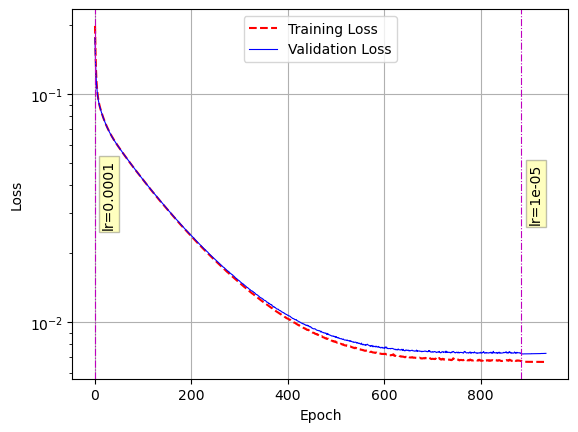

In [33]:
# plotting losses
dir_name_plot = dir_name_ARrnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot+'{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 51


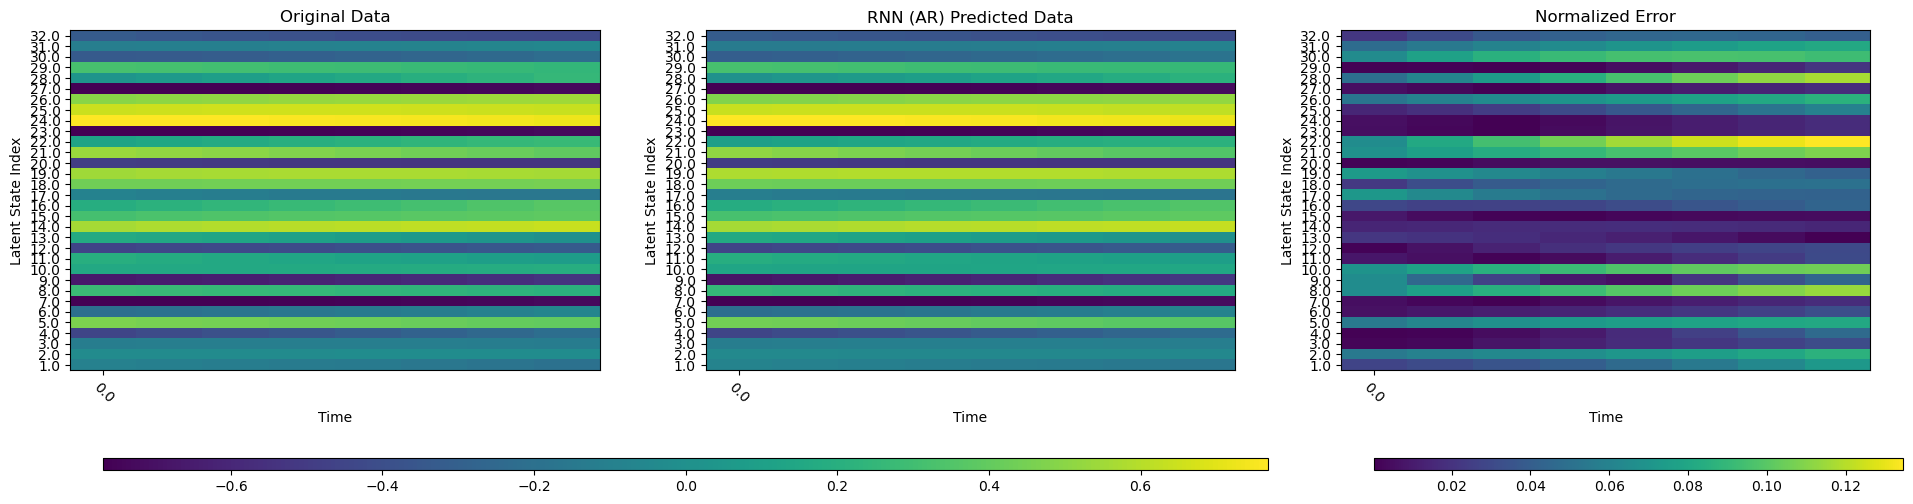

In [34]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ARrnn,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (AR) Predicted Data')

In [35]:
prediction.shape, data_out.shape

((1, 8, 32), (8, 32))

In [36]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 9


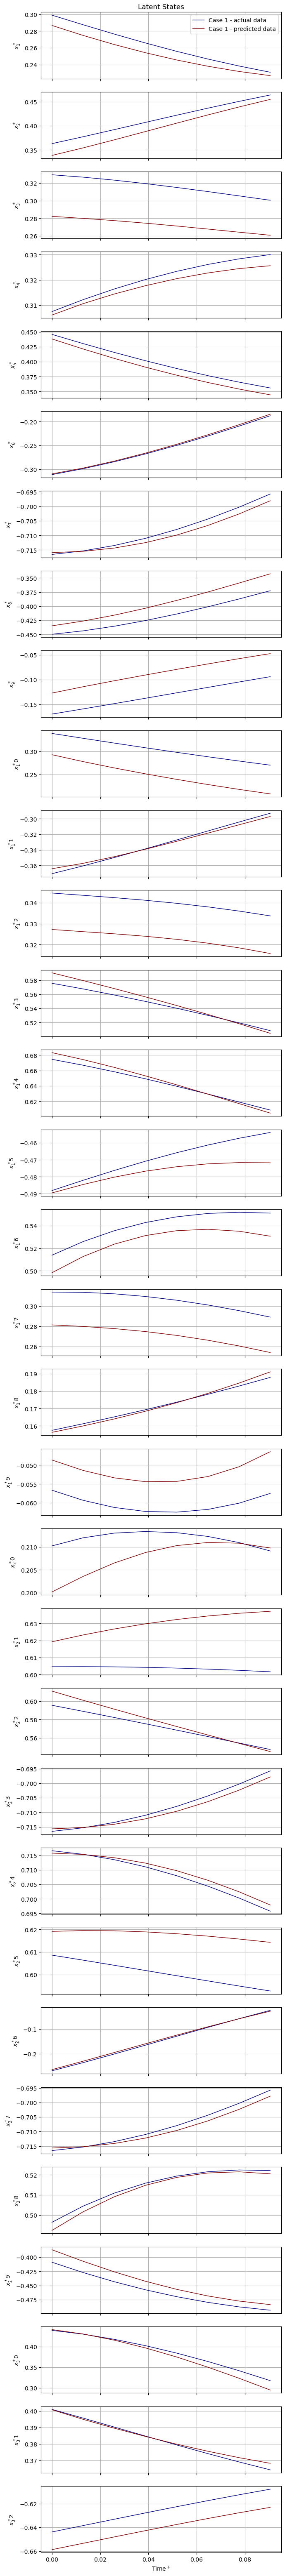

IndexError: index 0 is out of bounds for axis 0 with size 0

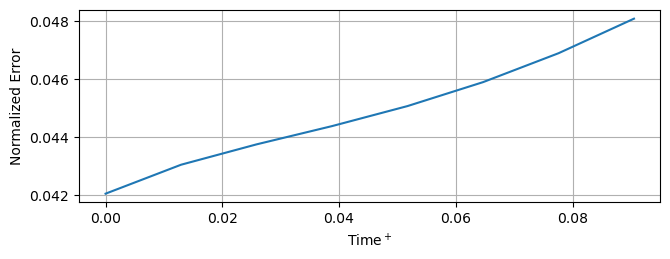

In [37]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
# for i in range(len(rnn_data_boundary_idx_arr)):
#     if data_idx < rnn_data_boundary_idx_arr[i]:
#         case_idx = i
#         break
case_idx = 0
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{}$'.format(i) for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error /= norm_sq_time_average(data_out)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0][0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()